<a href="https://colab.research.google.com/github/shubham-arote/Agentic-Corrective-Rag-System/blob/main/Research_assistant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --quiet -U langgraph langchain_community tavily-python wikipedia langchain-groq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.0/91.0 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.8/130.8 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.9/121.9 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 2.9 MB/s eta 0:00:00


In [ ]:
import os
from google.colab import userdata
os.environ['LANGCHAIN_TRACING_V2']='true'
os.environ['LANGCHAIN_ENDPOINT']='https://api.smith.langchain.com'
os.environ['LANGCHAIN_API_KEY']=userdata.get('LANGCHAIN_API_KEY')
os.environ['LANGCHAIN_PROJECT']=f"Research Assistance"
os.environ['TAVILY_API_KEY']=userdata.get('TAVILY_API_KEY')
os.environ['GROQ_API_KEY']=userdata.get('GROQ_API_KEY')

In [ ]:
from langchain_groq import ChatGroq
llm = ChatGroq(model="llama-3.3-70b-versatile")

In [ ]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

class Analyst(BaseModel):
    affiliation: str = Field(
        description = "Primary affiliation of the analyst."
    )
    name: str = Field(
        description= "Name of the analyst."
    )
    role: str = Field(
        description= "Role of the analyst in the context of the topic."
    )
    description: str = Field(
        description= "Description of the analyst focus, concerns and motives."
    )
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"

class Perspectives(BaseModel):
    analysts: List[Analyst] = Field(
        description = "Comprehensive list of analysts with their roles and affiliations"
    )

class GenerateAnalystState(TypedDict):
    topic: str # Research topic
    max_analysts: int # Number of analyst
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions

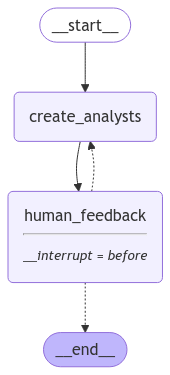

In [ ]:
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

analyst_instructions="""You are tasked with creating a set of AI analyst persons. Follow this instructions carefully:
1. First, review the research topic.
2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts:{human_analyst_feedback}.
3. Determine the most interesting themes based upon documents and / or feedback above.
4. Pick the top {max_analysts} themes.
5. Assign one analyst to each theme."""

def create_analysts(state: GenerateAnalystState):
    """Create analysts"""
    topic = state['topic']
    max_analysts = state['max_analysts']
    human_analyst_feedback = state.get('human_analyst_feedback', '')

    #Enforce structured output
    structured_llm = llm.with_structured_output(Perspectives)

    #System message
    system_message = analyst_instructions.format(topic=topic, human_analyst_feedback=human_analyst_feedback,
                                                 max_analysts=max_analysts)

    #Generate question
    analysts = structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Generate the set of analysts.")])

    #Write list of analysts to state
    return {"analysts": analysts.analysts}

def human_feedback(state: GenerateAnalystState):
    """ No-op node that should be interrupted on """
    pass

def should_continue(state: GenerateAnalystState):
    """ Return the next node to execute """
    #Check if human feedback
    human_analyst_feedback = state.get('human_analyst_feedback', None)
    if human_analyst_feedback:
        return "create_analysts"
    #Otherwise end
    return END

builder = StateGraph(GenerateAnalystState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", should_continue,["create_analysts", END])
memory= MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
# Input
max_analysts = 3
topic = '''The benefits of adoptiong Langgraph as an agent framemork'''
thread= {"configurable": {"thread_id": "1"}}

#Run the graph until first interruption
for event in graph.stream({"topic": topic, "max_analysts": max_analysts}, thread, stream_mode="values"):
    #Review
    analysts = event.get('analysts','')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Role: {analyst.role}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Description: {analyst.description}")
            print("-"*50)

Name: Dr. Emma Taylor
Role: Lead Analyst
Affiliation: University of Technology
Description: Expert in AI research
--------------------------------------------------
Name: Dr. Ryan Chen
Role: Senior Analyst
Affiliation: Harvard University
Description: Specialist in Natural Language Processing
--------------------------------------------------
Name: Dr. Sophia Patel
Role: Junior Analyst
Affiliation: Stanford University
Description: Expert in Computer Vision
--------------------------------------------------


In [ ]:
state = graph.get_state(thread)
state.next

('human_feedback',)

In [ ]:
graph.update_state(thread, {"human_analyst_feedback":
                            "Add someone from startup to add an entreprneur perspective"}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef75f21-0248-652d-8002-0a1eabce6134'}}

In [ ]:
for event in graph.stream(None, thread, stream_mode="values"):
    #Review
    analysts = event.get('analysts','')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Role: {analyst.role}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Description: {analyst.description}")
            print("-"*50)

Name: Dr. Emma Taylor
Role: Lead Analyst
Affiliation: University of Technology
Description: Expert in AI research
--------------------------------------------------
Name: Dr. Ryan Chen
Role: Senior Analyst
Affiliation: Harvard University
Description: Specialist in Natural Language Processing
--------------------------------------------------
Name: Dr. Sophia Patel
Role: Junior Analyst
Affiliation: Stanford University
Description: Expert in Computer Vision
--------------------------------------------------
Name: John Doe
Role: Founder
Affiliation: Startup
Description: Entrepreneur perspective
--------------------------------------------------
Name: Jane Smith
Role: Professor
Affiliation: Academia
Description: Theme 1 expert
--------------------------------------------------
Name: Bob Johnson
Role: Consultant
Affiliation: Industry
Description: Theme 2 expert
--------------------------------------------------


In [ ]:
# If we are satisfied then we simply supply no feedback to end
further_feedback = None
graph.update_state(thread, {"human_analyst_feedback": further_feedback}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef75f21-0a4a-6491-8004-0c425132450f'}}

In [ ]:
final_state = graph.get_state(thread)
analysts = final_state.values.get('analysts')

In [ ]:
final_state.next

()

In [ ]:
for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Role: {analyst.role}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Description: {analyst.description}")
            print("-"*50)

Name: John Doe
Role: Founder
Affiliation: Startup
Description: Entrepreneur perspective
--------------------------------------------------
Name: Jane Smith
Role: Professor
Affiliation: Academia
Description: Theme 1 expert
--------------------------------------------------
Name: Bob Johnson
Role: Consultant
Affiliation: Industry
Description: Theme 2 expert
--------------------------------------------------


In [ ]:
import operator
from typing import Annotated
from langgraph.graph import MessagesState

class InterviewState(MessagesState):
    max_num_turns: int # Number turns of conversations
    context: Annotated[list, operator.add] #Source docs
    analyst: Analyst # Analyst asking question
    interview: str # Interview transcript
    sections: list # Final key we duplicate in outer state for Send() API

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Search query for retrieval")

In [ ]:
question_instructions = """You are an analyst tasked with interviewing an expert to learn about a specific topic.
Your goal is boil down to interesting and specific insights related to your topic
1. Interesting: Insights that people will find surprising or non-obvious.
2. Specific: Insights that avoid generalities and include specific examples from the expert.
Here is your topic of focus and set of goals: {goals}
Begin by introducing yourself using a name that fits your persona, and then ask your question.
Continue to aske questions to drill down and refine your understanding of the topic.
When you are satisfied with your understanding, complete the interview with:"Thank you so much for your help!"
Remember to stay in character throughout your response, reflecting the persona and goals provided to you."""

def generate_question(state: InterviewState):
    """Node to generate question"""
    #get state
    analyst = state["analyst"]
    messages = state["messages"]

    #generate question
    system_message = question_instructions.format(goals=analyst.persona)
    question = llm.invoke([SystemMessage(content= system_message)] + messages)
    return {"messages": [question]}


Generate answer: parallelization

In [ ]:
#Web search tool
from langchain_community.tools.tavily_search import TavilySearchResults
tavily_search = TavilySearchResults(max_results=3)
#Wikipedia search tool
from langchain.document_loaders import WikipediaLoader

In [ ]:
from langchain_core.messages import get_buffer_string
#Search query writing

search_instructions = SystemMessage(content=f"""You will be given a conversation between analyst and an expert.
Your goal is to generate a well-structured query for use in retrieval and / or web_search related to the conversation.
First, analyse full conversation.
Pay attention to final question posted by the analyst,
Convert this final question into well-structured web search query.""")

def search_web(state: InterviewState):
    """Retrieve documents from web search"""
    #Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions] +state['messages'])

    #Search
    search_docs = tavily_search.invoke(search_query.search_query)
    #Format
    formated_search_docs = "\n\n----\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )
    return {"context": [formated_search_docs]}

def search_wikipedia(state: InterviewState):
    """Retrieve documents from wikipedia"""
    #Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions] +state['messages'])

    #Search
    search_docs = WikipediaLoader(query=search_query.search_query,
                                  load_max_docs =2).load()

    #Format
    formated_search_docs = "\n\n----\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page","")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )
    return {"context": [formated_search_docs]}

answer_instructions = """You are an expert being interviewed by an analyst.
Here is analyst area of focus: {goals}
Your goal is to answer a question posed by the interviewer.
To answer question, use this context:
{context}
When answering questions, follow these guidelines:
1. Use only the information provided in the context.
2. Do not introduce external information or make asssumptions beyond what is explicitly stated in the context
3. The context contain sources of the topic of each individual documnet.
4. Include these sources in your answer next to any relevant statements . For examples, for source #1 use[1]
5. List your sources in order at the bottom of your answer.[1]Source 1, [2]Source 2, etc
6. If the socurces is: <Document source="assistant/docs/llama3_1.pdf" page= "7"/> then just list:
[1] assistant/docs/llama3_1.pdf,page=7
And skip the addition of the brackets as well as the Doucment source preamble in your citation"""

def generate_answer(state: InterviewState):
    """Node to generate answer"""
    #Get state
    analyst = state["analyst"]
    messages = state["messages"]
    context = state["context"]

    #Generate answer
    system_message = answer_instructions.format(goals=analyst.persona, context=context)
    answer = llm.invoke([SystemMessage(content=system_message)] + messages)

    #Name message as coming from expert
    answer.name = "expert"

    #append it to state
    return {"messages": [answer]}

def save_interview(state: InterviewState):
    """state interview"""
    #Get messages
    messages = state["messages"]

    #Conver interview to a string
    interview = get_buffer_string(messages)

    #Append to state
    return {"interview": interview}

def route_messages(state: InterviewState, name: str= "expert"):
    """Route between question and answer."""
    #Get messages
    messages = state["messages"]
    max_num_turns = state.get("max_num_turns", 2)

    #Check the number of expert answers
    num_responses = len([m for m in messages if isinstance(m, AIMessage) and m.name == name])

    #End if expert has answered more than the max turns
    if num_responses < max_num_turns:
        return "save_interview"

    #This router will run after each question answer pair
    # Get the last question asked to check if it signals end of discussion

    last_question = messages[-2]

    if "Thank you so much for your help!" in last_question.content:
        return "save_interview"
    return "ask_question"

section_writer_instructions = """You are an expert technical writer.
Your task is to create a short, easily digestible section of a report based on a set of source documents.
1. Analyze the content of the source documents:
-The name of  each source document is at the start of the document, with the <Document tag.

2. Create a report  structur using markdown formatting:
- Use ## for the section title
- Use ### for sub-sections headers

3. Write the report following this structure:
a. Title (## header)
b. Summary(### header)
c. Sources(### header)

4. Make your title engaging based upon the focus area of the analyst:
{focus}

5. For the summary section:
-Set up summary with general background / context related to focus area of analyst
-Emphasize what is novel, interesting, or surprising about the insights gathered from the interview
-Create a numbered list of source documents, as you use them
-Do not mention the names of interviewers or expert
-Aim for appproximately 400 words maximum
-Use numbered sources in your report(e.g., [1], [2]) based on information from source documents

6. In the Sources setion:
-Include all sources used in your report
-Provide full links to relevant websites or specific document paths
-Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
-It will look like:

### Sources
[1] Link or Document name
[2] Link or Document name

7. Be sure to combine sources. For example this is not correct:
[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

There should be no redundant sources. It should simply be:
[3] https://ai.meta.com/blog/meta-llama-3-1/

8. Final review:
-Ensure the report follows the required structure.
-Include no preamble before the title of the report.
-Check that all guidelines have been followed"""

def write_section(state: InterviewState):
    """Node to answer the question"""
    #Get state
    interview = state["interview"]
    context = state["context"]
    analyst = state["analyst"]

    #write section using either the gathered source docs from interview (context) or the interview itself (interview)
    system_message = section_writer_instructions.format(focus= analyst.description)
    section = llm.invoke([SystemMessage(content=system_message)] + [HumanMessage(content=f"Use this source to write your section:{context}")])

    #Append to state
    return {"sections": [section.content]}

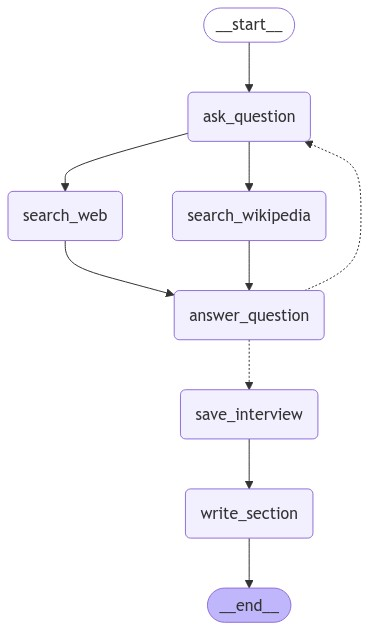

In [ ]:
interview_builder = StateGraph(InterviewState)
interview_builder.add_node("ask_question", generate_question)
interview_builder.add_node("search_web", search_web)
interview_builder.add_node("search_wikipedia", search_wikipedia)
interview_builder.add_node("answer_question", generate_answer)
interview_builder.add_node("save_interview", save_interview)
interview_builder.add_node("write_section", write_section)

interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question", "search_web")
interview_builder.add_edge("ask_question", "search_wikipedia")
interview_builder.add_edge("search_web", "answer_question")
interview_builder.add_edge("search_wikipedia", "answer_question")
interview_builder.add_conditional_edges("answer_question", route_messages, ["ask_question","save_interview"])
interview_builder.add_edge("save_interview", "write_section")
interview_builder.add_edge("write_section", END)
memory= MemorySaver()
interview_graph = interview_builder.compile(checkpointer=memory).with_config(run_name="Conduct Interview")
display(Image(interview_graph.get_graph().draw_mermaid_png()))

In [ ]:
!pip install langchain-google-genai

In [ ]:
os.environ['GOOGLE_API_KEY']=userdata.get('GEMINI_API_KEY')

In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGroq(
    model="llama-3.1-8b-instant")

In [ ]:
from IPython.display import display, Markdown
messages = [HumanMessage(content=f"So you were writing an article on {topic}")]
thread = {"configurable": {"thread_id": "1"}}
interview = interview_graph.invoke({"analyst": analysts[0], "messages": messages, "max_num_turns":2}, thread)
Markdown(interview['sections'][0])

Parallelize interviews: Map-reduce

In [ ]:
import operator
from typing import List, Annotated
from typing_extensions import TypedDict

class ResearchGraphState(TypedDict):
    topic: str #Research topic
    max_analysts: int # Number of analyst
    human_analyst_feedback : str # Human feedback
    analysts: List[Analyst] # Analyst asking questions
    sections: Annotated[list, operator.add] #send API() key
    introduction: str # Introduction for final report
    content: str # Content for final report
    conclusion: str # Conclusion for final report
    final_report: str # Final report

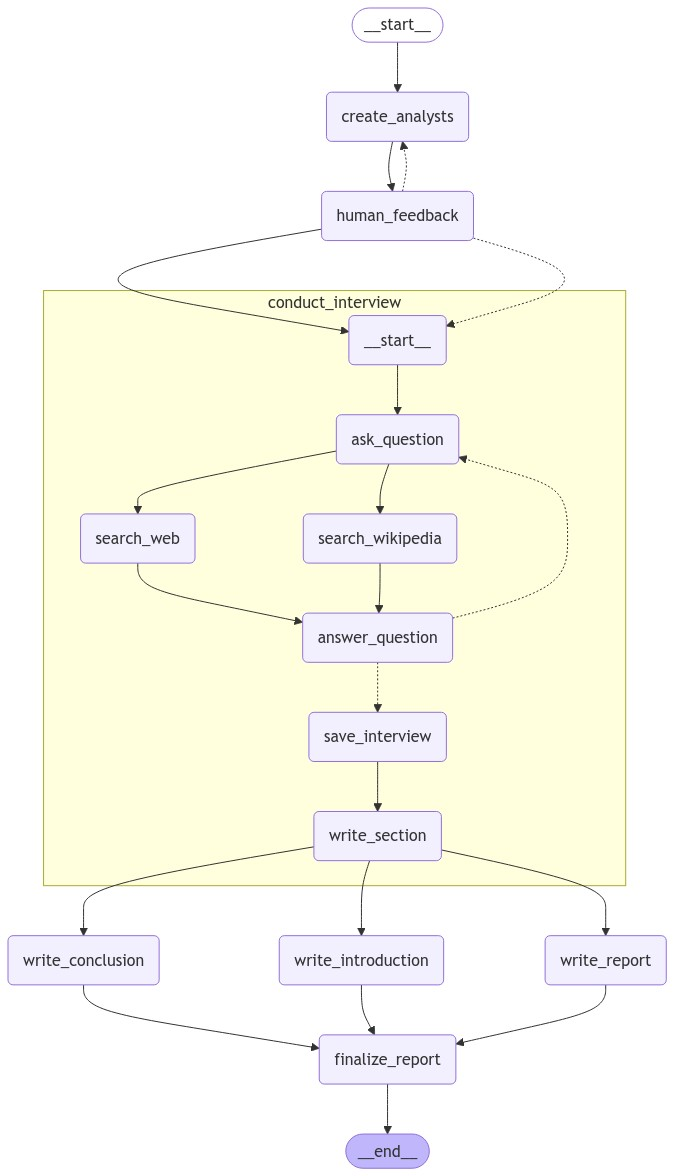

In [ ]:
from langgraph.constants import Send
def inititate_all_interviews(state: ResearchGraphState):
    """This is the map step where we run each interview subgraph using Send API"""
    #Check if human feedback
    human_analyst_feedback = state.get('human_analyst_feedback')
    if human_analyst_feedback:
        return "create_analysts"
    #Otherwise kick off interviews in parallel via Send() API
    else:
        topic = state['topic']
        return [Send("conduct_interview", {"analyst": analyst,
                                           "topic": topic,
                                           "messages":[HumanMessage(
                                               content=f"So you said you were writing an article on {topic}?")
                                           ]}) for analyst in state['analysts']]
report_writer_instruction = """You are a technical writer creating a report on this overall topic:
{topic}
You have team of analysts. Each analyst has done two things:
1. They conducted an interview with an expert on a specific sub-topic.
2. They write up their finding into a memo.

Your task:
1. You will be given a collection of memos from your analysts.
2. Think carefully about the insights from each memo.
3. Consolidate these into a crisp overall summary that ties together the central ideas from all the memos.
4. Summarize the central points in each memo into a cohesive single narrative.

To format your report:
1. Use markdown formatting.
2. Include no pre-amble for the report.
3. Start your report with a single title header: ##Insights
4. Use no sub-heading.
5. Do not mention any analyst names in your report.
6. Preserve any citations in the memos, which will be annotated in brackets, for example [1] or [2].
7. Create a final, consolidated list of sources and add to a Sources section with the '## Sources'header.
8. List your sources in order and do not repeat.

[1] Source 1
[2] Source 2

Here are the memos from your analysts to build your report from:
{context}"""

def write_report(state: ResearchGraphState):
    #Full set of sections
    sections = state['sections']
    topic = state['topic']

    #Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in  sections])
    #Summarize sections in final report

    system_message = report_writer_instruction.format(topic=topic, context=formatted_str_sections)
    report = llm.invoke([SystemMessage(content=system_message)] + [HumanMessage(content=f"write report based upon this memos")])

    #Append to state
    return {"content": report.content}

intro_conclusion_isntructions = """You are a technical writer finishing a reprot on {topic}
You will be given all of the sections of the report.
Your job is to write a crisp and compelling introduction or conclusion section.
The user will instruct you whether to write the introduction or conclusion.
Include no pre-amble for either section.
Target around 100 words, crisply proviewing(for introduction) or recapping (for conclusion) all of the sections of the report.
Use markdown formatting.
For your introduction, create a compelling title and use the #header for the title.
For your indroduction , use ## Introduction as the section header.
For your conclusion, use ## Conclusion as the section header.
Here are the sections to reflect on for writing: {formated_str_sections}"""

def write_introduction(state: ResearchGraphState):
    # Full set of section
    sections = state['sections']
    topic = state['topic']

    #Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in  sections])

    instructions = intro_conclusion_isntructions.format(topic=topic, formated_str_sections=formatted_str_sections)
    intro = llm.invoke([instructions] + [HumanMessage(content=f"write report introduction")])
    return {"introduction": intro.content}

def write_conclusion(state: ResearchGraphState):
    # Full set of section
    sections = state['sections']
    topic = state['topic']

    #Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in  sections])
    #Summarize sections into a final report
    instructions = intro_conclusion_isntructions.format(topic=topic, formated_str_sections=formatted_str_sections)
    conclusion = llm.invoke([instructions] + [HumanMessage(content=f"write report conclusion")])
    return {"conclusion": conclusion.content}

def finalize_report(state: ResearchGraphState):
    """ This is reduce step where we gather all the sections , combine them and reflect on them to write intro/conclusion"""
    #Save full report
    content = state["content"]
    if content.startwith["## Insights"]:
        content = content.strip["## Insights"]
    if "## Sources" in content:
        try:
            content, sources = content.split("\n## Sources\n")
        except:
            sources = None
    else:
        sources =None
    final_report = state["introduction"] + "\n\n----\n\n" + content + "\n\n----\n\n" + state["conclusion"]
    if sources is not None:
        final_report += "\n\n----\n\n" + sources
    return {"final_report": final_report}


builder = StateGraph(ResearchGraphState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_node("conduct_interview", interview_graph)
builder.add_node("write_report", write_report)
builder.add_node("write_introduction", write_introduction)
builder.add_node("write_conclusion", write_conclusion)
builder.add_node("finalize_report", finalize_report)

builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_edge("human_feedback", "conduct_interview")
builder.add_conditional_edges("human_feedback", inititate_all_interviews, ["create_analysts", "conduct_interview"])
builder.add_edge("conduct_interview", "write_report")
builder.add_edge("conduct_interview", "write_introduction")
builder.add_edge("conduct_interview", "write_conclusion")
builder.add_edge(["write_conclusion", "write_report", "write_introduction"], "finalize_report")
builder.add_edge("finalize_report", END)

memory = MemorySaver()
graph = builder.compile(checkpointer=memory)
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [ ]:
max_analysts = 2
topic ='''The benefits of adopting Langraph as an agent framework '''
thread = {"configurable": {"thread_id": "3"}}

for event in graph.stream({"topic": topic, "max_analysts": max_analysts}, thread, stream_mode="values"):
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-"*50)

Name: Emily Chen
Affiliation: MIT
Role: AI research analyst
Description: Expert in AI and machine learning
--------------------------------------------------
Name: David Lee
Affiliation: Stanford
Role: NLP research analyst
Description: Expert in natural language processing
--------------------------------------------------


KeyError: 'analyst'

In [ ]:
graph.update_state(thread, {"human_analyst_feedback":
                            "Add in the CEO of gen ai native startup"}, as_node= "human_feedback")

{'configurable': {'thread_id': '3',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef75f3b-b5d2-6a70-8002-cf6f9fc22b00'}}

In [ ]:
for event in graph.stream({"topic": topic, "max_analysts": max_analysts}, thread, stream_mode="values"):
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-"*50)

In [ ]:
graph.get_state(thread).next

('create_analysts', 'conduct_interview')

In [ ]:
for event in graph.stream(None, thread, stream_mode="updates"):
    print("---Node---")
    node_name = next(iter(event.keys()))
    print(node_name)

EmptyInputError: Received no input for __start__